# Pychenette n° 3 : Visualiser les formalités CNIL et l'évolution de la législation

**Pychenette** est une série de notebooks, en français, courts et originaux avec Python.

**Auteur** : Francis Wolinski

Pour tout commentaire : pychenette[at]yotta-conseil.fr

#### L'idée de ce notebook

A partir du fichier des formalités préalables accomplies auprès de la CNIL depuis 1979, on visualise le nombre de formalités, ainsi que les modifications législatives du texte initial.

Données utilisées :
- Pour les formalités, on utilise le fichier `formalites-prealables-cnil.csv` : https://public.opendatasoft.com/explore/dataset/formalites-prealables-cnil/information/?flg=fr
- Pour modifications législatives du texte initial, on utilise le texte de la page web : https://www.legifrance.gouv.fr/loda/id/JORFTEXT000000886460/

<a href="notebooks/Pychenette-3-Visualiser-les-formalites-CNIL-et-l-evolution-de-la-legislation.ipynb">Accès au notebook</a>

<a href="https://pychenette.yotta-conseil.fr/"><i class="fa fa-home"></i></a>

In [1]:
# imports
import datetime
import locale
import os
import re

import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

### Chargement des formalités accomplies

Les formalités accomplies sont recensées dans un fichier CSV pour lequel seule la colonne "Date d'enregistrement" est utilisée. Il y a 1,4 M de lignes.

On détermine le nombre de formalités par an. Le fichier n'a pas été mis à jour depuis 2017, sachant que la réglementation RGPD est intervenue en 2018 et a modifié en profondeur le dispositif législatif.

In [2]:
df = pd.read_csv("formalites-prealables-cnil.csv",
                  sep=";",
                  parse_dates=["Date d'enregistrement"],
                  usecols=["Date d'enregistrement"])
df.shape

(1405434, 1)

In [3]:
nb_formalites = df.groupby("Date d'enregistrement").size().resample('Y').sum().iloc[:-1]
len(nb_formalites)

39

### Chargement des modifications législatives

On extrait de la page HTML du site *légifrance* les différents textes qui sont venus modifier la Loi n° 78-17 du 6 janvier 1978 relative à l'informatique, aux fichiers et aux libertés.

Les textes à collecter sont cités dans les tags HTML "a". Une expression régulière permet d'extraire la nature des textes (Loi ou Ordonnance), son numéro ainsi que la date. Pour pouvoir parser les dates avec Python, il faut compléter avec un 0 à gauche les jours lorsqu'ils ne sont composés que d'un seul chiffre.

On construit un `DataFrame` à deux colonnes avec les dates et les textes correspondants.

In [4]:
data = []

html = open("JORFTEXT000000886460.html").read()

soup = BeautifulSoup(html)

for a in soup.find_all("a"):
    text = a.text
    if (text.lower().find("n°") != -1) \
        and ((text.lower().find("loi") != -1) or (text.lower().find("ordonnance") != -1)):
        m = re.search(r"(loi|ordonnance) n°\s*(\d+-\d+) du (\d+ \w+ \d+)", text, flags=re.I)
        if m:
            texte, no, date = m.groups()
            if re.match('^\d ', date):
                date = "0" + date
        data.append((date, f"{texte} n° {no}"))

In [5]:
locale.setlocale(locale.LC_TIME, 'fr' if os.name == 'nt' else 'fr_FR.utf8')

df_textes = pd.DataFrame(data, columns=["date", "texte"])
df_textes = (df_textes.drop_duplicates()
                      .assign(date=lambda df_: pd.to_datetime(df_["date"], format="%d %B %Y"),
                              texte=lambda df_: df_["texte"].str.capitalize())
                      .sort_values(by="date")
                      .reset_index(drop=True)
          )
df_textes

,date,texte
0,1988-03-11,Loi n° 88-227
1,1992-12-16,Loi n° 92-1336
2,1994-07-01,Loi n° 94-548
3,2000-04-12,Loi n° 2000-321
4,2000-09-19,Ordonnance n° 2000-916
5,2004-08-06,Loi n° 2004-801
6,2005-12-08,Ordonnance n° 2005-1516
7,2016-01-26,Loi n° 2016-41
8,2016-10-07,Loi n° 2016-1321
9,2017-01-20,Loi n° 2017-55


### Visualisation du nombre de formatilés au regard des évolutions législatives

On visualise le nombre de formalités effectuées annuellement entre 1979 et 2017.

On annote le graphique avec les évolutions législatives sur la période.

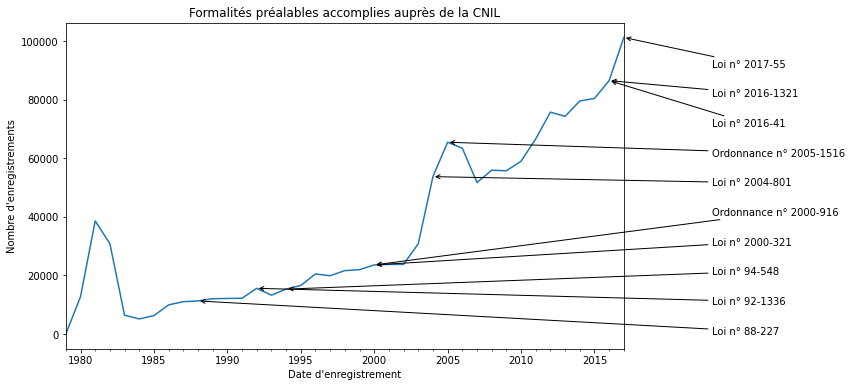

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.set_ylabel("Nombre d'enregistrements")
ax.set_title("Formalités préalables accomplies auprès de la CNIL")

nb_formalites.plot(ax=ax)

df_textes = df_textes.loc[df_textes["date"] <= nb_formalites.index.max()]

x = nb_formalites.index.max() + datetime.timedelta(days=2000)
y = nb_formalites.max() / len(df_textes)

for i, date, loi in df_textes.itertuples():
    
    try:
        value = nb_formalites[date.replace(month=12, day=31)]
    except:
        value = 0
        
    ax.annotate(loi,
                xy=(date, value),
                xytext=(x, i * y),
                fontsize=10,
                horizontalalignment='left',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))